In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import os
import random
from torch.utils.data import Subset

In [2]:
#Select your mode
option=['IF','FF']
option1=['IN','FI']
opt_val=0 # 0 for I to F and 1 for F to I
selected=option[opt_val]
selected1=option1[opt_val]

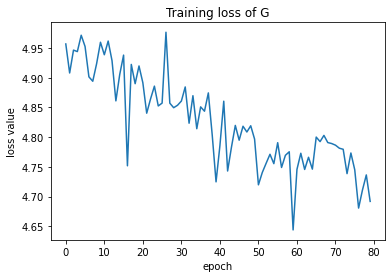

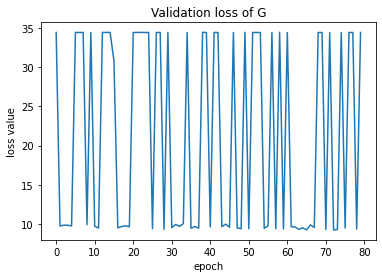

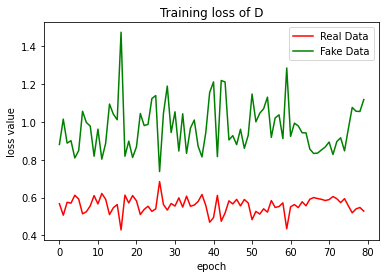

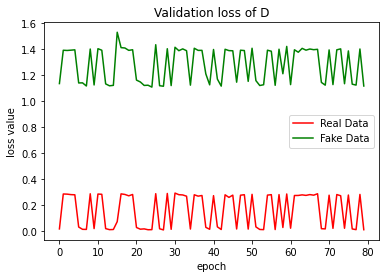

In [3]:
#plot the loss functions
#also add: addition of two (or more) files

#separate
common_dir=f'/vol/calvin/data/dbhatnagar/Results_Summary_En/Plots_{option[opt_val]}/'
gen_loss_tr=np.load(common_dir +'train_loss_G.npy')
plt.plot(gen_loss_tr)
plt.title('Training loss of G')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

gen_loss_val=np.load(common_dir +'val_loss_G.npy')
plt.plot(gen_loss_val)
plt.title('Validation loss of G')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

disc_loss_real_tr=np.load(common_dir +'train_loss_D_real.npy')
disc_loss_fake_tr=np.load(common_dir +'train_loss_D_fake.npy')
plt.plot(disc_loss_real_tr,'r',label="Real Data")
plt.plot(disc_loss_fake_tr,'g',label="Fake Data")
plt.title('Training loss of D')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

disc_loss_real_val=np.load(common_dir +'val_loss_D_real.npy')
disc_loss_fake_val=np.load(common_dir +'val_loss_D_fake.npy')
plt.plot(disc_loss_real_val,'r',label="Real Data")
plt.plot(disc_loss_fake_val,'g',label="Fake Data")
plt.title('Validation loss of D')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

In [3]:
#loads a model 

def cnn_block(in_channels,out_channels,kernel_size,stride,padding, first_layer = False):

   if first_layer:
       return nn.Conv3d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)
   else:
       return nn.Sequential(
           nn.Conv3d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
           nn.BatchNorm3d(out_channels,momentum=0.1,eps=1e-5),
           )

def tcnn_block(in_channels,out_channels,kernel_size,stride,padding,output_padding=0, first_layer = False):
   if first_layer:
       return nn.ConvTranspose3d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding)

   else:
       return nn.Sequential(
           nn.ConvTranspose3d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding),
           nn.BatchNorm3d(out_channels,momentum=0.1,eps=1e-5),
           )
   
#parameters

gf_dim = 64
df_dim = 64
in_w = in_h = in_d = 128 #dimensions of a single data sample
c_dim = 1 #color channels, 1 for grayscale

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#generator

class Generator(nn.Module):
 def __init__(self,instance_norm=False):#input : 1 x 128^3
   super(Generator,self).__init__()
   self.e1 = cnn_block(c_dim,gf_dim,4,2,1, first_layer = True) #64 x 64^3
   self.e2 = cnn_block(gf_dim,gf_dim*2,4,2,1) #128 x 32^3
   self.e3 = cnn_block(gf_dim*2,gf_dim*4,4,2,1) #256 x 16^3
   self.e4 = cnn_block(gf_dim*4,gf_dim*8,4,2,1) #512 x 8^3
   self.e5 = cnn_block(gf_dim*8,gf_dim*8,4,2,1) #512 x 4^3
   self.e6 = cnn_block(gf_dim*8,gf_dim*8,4,2,1) #512 x 2^3
   self.e7 = cnn_block(gf_dim*8,gf_dim*8,4,2,1,first_layer=True) #512 x 1^3 #bottleneck

   self.d1 = tcnn_block(gf_dim*8,gf_dim*8,4,2,1) # 512 x 2^3
   self.d2 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1) #512 x 4^3
   self.d3 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1) #512 x 8^3
   self.d4 = tcnn_block(gf_dim*8*2,gf_dim*4,4,2,1) #256 x 16^3
   self.d5 = tcnn_block(gf_dim*4*2,gf_dim*2,4,2,1) #128 x 32^3
   self.d6 = tcnn_block(gf_dim*2*2,gf_dim*1,4,2,1) #64 x 64^3
   self.d7 = tcnn_block(gf_dim*1*2,c_dim,4,2,1, first_layer = True)#1 x 128^3
   self.tanh = nn.Tanh()

 def forward(self,x):
   e1 = self.e1(x)
   #print(e1.shape,"e1")
   e2 = self.e2(F.leaky_relu(e1,0.2))
   #print(e2.shape,"e2")
   e3 = self.e3(F.leaky_relu(e2,0.2))
   #print(e3.shape,"e3")
   e4 = self.e4(F.leaky_relu(e3,0.2))
   #print(e4.shape,"e4")
   e5 = self.e5(F.leaky_relu(e4,0.2))
   #print(e5.shape,"e5")
   e6 = self.e6(F.leaky_relu(e5,0.2))
   #print(e6.shape,"e6")
   e7 = self.e7(F.leaky_relu(e6,0.2))
   #print(e7.shape,"e7")
   #e7 = self.e7(F.leaky_relu(e6,0.2))
   #e8 = self.e8(F.leaky_relu(e7,0.2))
   #d0=self.d0(e6)
   #print(d0.shape,"d0")
   d1 = torch.cat([F.dropout(self.d1(F.relu(e7)),0.5,training=True),e6],1)
   #print(d1.shape,"d1")
   d2 = torch.cat([F.dropout(self.d2(F.relu(d1)),0.5,training=True),e5],1)
   #print(d2.shape,"d2")
   d3 = torch.cat([F.dropout(self.d3(F.relu(d2)),0.5,training=True),e4],1)
   #print(d3.shape,"d3")
   d4 = torch.cat([self.d4(F.relu(d3)),e3],1)
   #print(d4.shape,"d4")
   d5 = torch.cat([self.d5(F.relu(d4)),e2],1)
   #print(d5.shape,"d5")
   d6 = torch.cat([self.d6(F.relu(d5)),e1],1)
   #print(d6.shape,"d6")
   d7 = self.d7(F.relu(d6))
   #print(d7.shape,"d7")


   return self.tanh(d7)



def test():
  x=torch.randn((1,1,128,128,128))
  model=Generator()
  preds=model(x)
  print(preds.shape)

#test()




In [11]:
#LOAD THE MODEL

generator_loaded = Generator().to(device)  # create an instance of the generator model
generator_loaded.load_state_dict(torch.load(f'/vol/calvin/data/dbhatnagar/Results_Summary_1/Vbestmodel_Gen_{selected}.pth',map_location=torch.device('cpu')))# load the saved model parameters
#generator_loaded.load_state_dict(torch.load('/users/dbhatnagar/Vbestmodel_Gen.pth',map_location=torch.device('cpu')))# load the saved model parameters
generator_loaded.eval()

Generator(
  (e1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (e2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (e3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (e4): Sequential(
    (0): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (e5): Sequential(
    (0): Conv3d(512, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (e6): Sequential(
    (0): Conv3d(512, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  

In [5]:
#new transformations
def log_transform(arr):
    a=4
    # Create a copy of the original array
    transformed_arr = np.copy(arr)
    
    # Add a constant offset to shift the values to a positive range
    transformed_arr += 1 + 1e-9
    
    # Apply the transformation equation to the array
    transformed_arr = (2 * transformed_arr / (transformed_arr + a)) - 1
    
    return transformed_arr

def log10_transform(arr):
  OG_arr=np.copy(arr)
  OG_arr=OG_arr + 1
  return np.log10(OG_arr)

def inverse_log_transform(arr):
  a=4
  # Create a copy of the original array
  in_transformed_arr = np.copy(arr)
  # Apply the in transformation equation to the array
  in_transformed_arr = (a * (1 + in_transformed_arr))/(1 -in_transformed_arr)
  in_transformed_arr -= 1 
  return in_transformed_arr

In [6]:
#TestSet

t_i=7000
t_f=7100

def loads_arrays(in_val,fin_val,in_=True):
    loaded_array=[]
    loaded_list=[]
    for i in range(in_val,fin_val):
        k=i+1
        if in_==True:
            loaded_array=np.load('/vol/calvin/data/dbhatnagar/IF_128/IN_File_128_{0}.npy'.format(k))
            loaded_list.append(loaded_array)

        else:
            loaded_array=np.load('/vol/calvin/data/dbhatnagar/FF_128/FI_File_128_{0}.npy'.format(k))
            loaded_list.append(loaded_array)

    return loaded_list


INITIAL_TEST=loads_arrays(t_i,t_f,in_=True)
FINAL_TEST=loads_arrays(t_i,t_f,in_=False)

random sample: 43
mean values
2.233719e-09 train sample
-0.62868404 TRANSFORMED sample
2.2773747e-09 expected output sample


Text(0, 0.5, 'expected output sample')

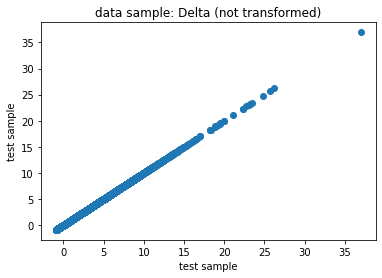

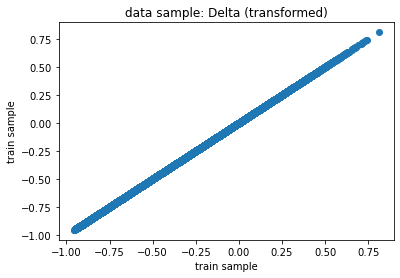

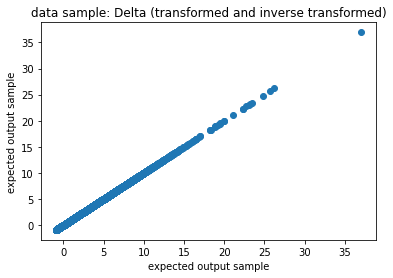

In [7]:
#Compare properties of test set and expected output set
lenn=t_f-t_i
ind=random.randint(0,lenn-1)
#ind=8
print("random sample:", ind)
print('mean values')
test_sample=FINAL_TEST[ind]
print(np.mean(test_sample),'train sample')

train_sample=log_transform(FINAL_TEST[ind])
print(np.mean(train_sample),'TRANSFORMED sample')
output_sample=inverse_log_transform(train_sample)
print(np.mean(output_sample),'expected output sample')
#scatter plot check

plt.scatter(test_sample,test_sample)
plt.title('data sample: Delta (not transformed)')
plt.xlabel('test sample')
plt.ylabel('test sample')
plt.figure()
plt.scatter(train_sample,train_sample)
plt.title('data sample: Delta (transformed)')
plt.xlabel('train sample')
plt.ylabel('train sample')
plt.figure()
plt.scatter(output_sample,output_sample)
plt.title('data sample: Delta (transformed and inverse transformed)')
plt.xlabel('expected output sample')
plt.ylabel('expected output sample')


In [8]:
#prepares test loader

transformed_arrays_IF = [log_transform(arr) for arr in INITIAL_TEST]
transformed_arrays_FF = [log_transform(arr) for arr in FINAL_TEST]
X_test=torch.Tensor(np.array(transformed_arrays_IF))
Y_test=torch.Tensor(np.array(transformed_arrays_FF))

test_set = TensorDataset(X_test, Y_test)
batch_size=1
test_loader= torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [9]:
#Uses loaded model and gives visual output and stats of 5 random samples

test_length=100 #number of test samples
num_random_samples=2
first_five_indices = list(range(5))
five_subset = Subset(test_loader.dataset, first_five_indices)
random_indices = random.sample(range(test_length), num_random_samples)
random_subset = Subset(test_loader.dataset, random_indices)
#new_loader = torch.utils.data.DataLoader(random_subset, batch_size=batch_size, shuffle=True)
new_loader = torch.utils.data.DataLoader(five_subset, batch_size=batch_size, shuffle=False)

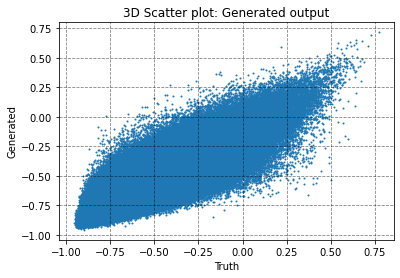

-0.7370813 vmin
-0.48516014 vmax


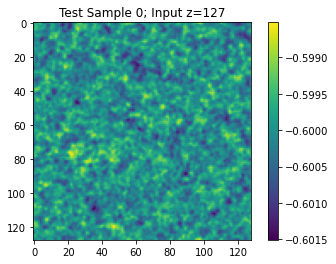

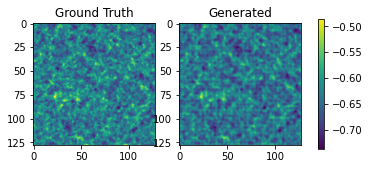

Correlation coefficient: 0.6914151617092318


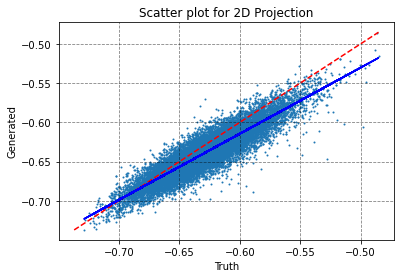

<Figure size 432x288 with 0 Axes>

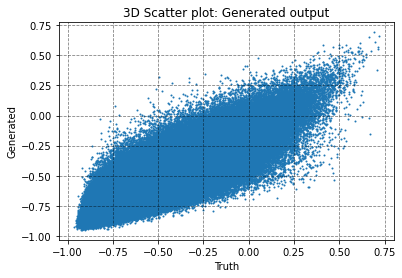

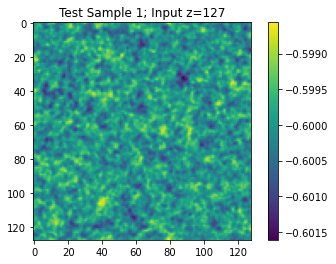

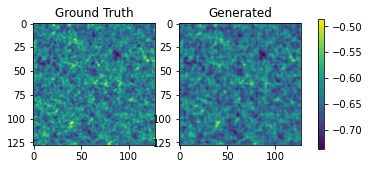

Correlation coefficient: 0.7109990567024861


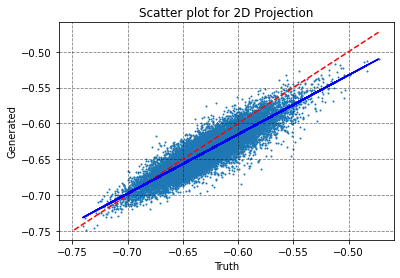

<Figure size 432x288 with 0 Axes>

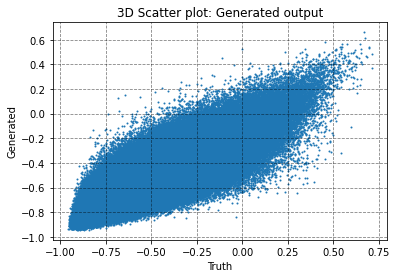

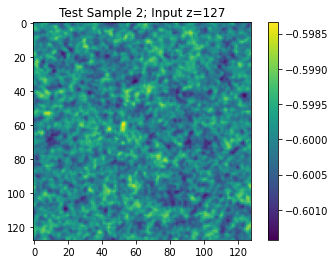

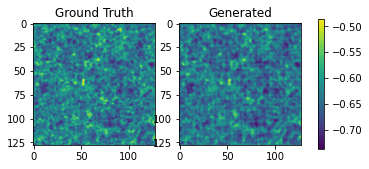

Correlation coefficient: 0.7382292605419759


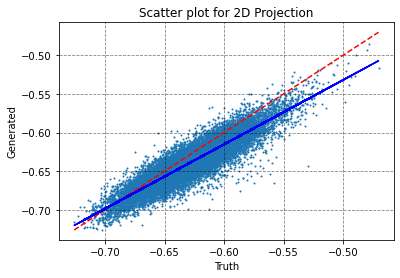

<Figure size 432x288 with 0 Axes>

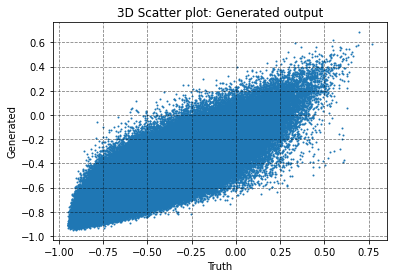

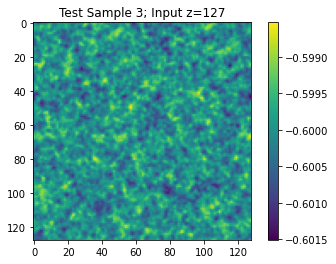

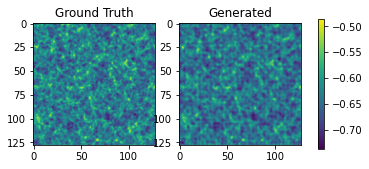

Correlation coefficient: 0.8087735426767709


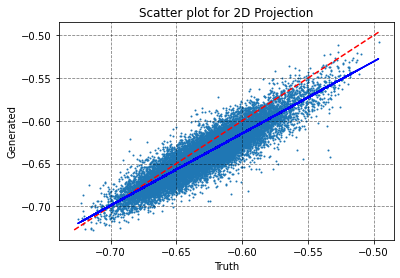

<Figure size 432x288 with 0 Axes>

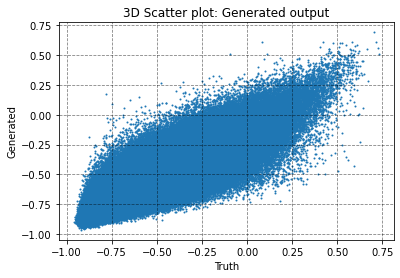

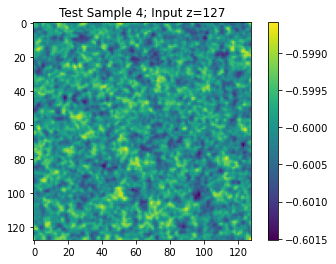

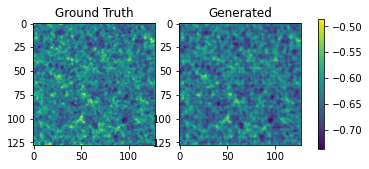

Correlation coefficient: 0.8406309725089719


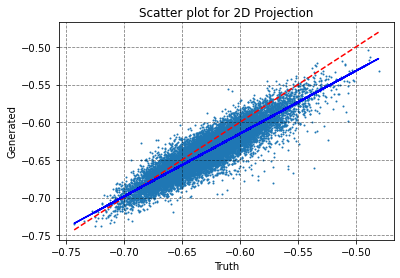

<Figure size 432x288 with 0 Axes>

In [12]:
for i, data in enumerate(new_loader):
    x, y = data
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    #size of both 1 x 1 x128 x128 x128
    x = x.to(device)
    y = y.to(device)
    generated_samples = generator_loaded(x)
    k = generated_samples[0].squeeze(0)
    k1 = k.cpu().detach()
    k2=k1.numpy()

    data1=y.cpu().numpy() #truth 1 x 1 x 128 x128 x128
    data1=data1.squeeze(0)
    data1=data1.squeeze(0)
    data3=x.cpu().numpy() #input (initial or final) 1 x 1 x128 x128 x128
    data3=data3.squeeze(0) 
    data3=data3.squeeze(0)
    data2=k2 #generated #128 x 128 x 128 log transformed


    # data1=inverse_log_transform(data1)
    # data2=inverse_log_transform(data2)
    # data3=inverse_log_transform(data3)

    # data1=log10_transform(data1)
    # data2=log10_transform(data2)
    # data3=log10_transform(data3)
     # Plot the third data
    plt.figure()
    plt.scatter(data1, data2,s=1)
    plt.xlabel('Truth')
    plt.ylabel('Generated')
    plt.title(f'Sample{i}')
    plt.grid(True, linestyle='--', alpha=0.5, zorder=1,color="black")
    
    #plt.title(r'3D Scatter plot $\log_{10}(1 + \delta) $')
    plt.title(r'3D Scatter plot: Generated output')
    #plt.title(r'3D Scatter plot $\delta$')
    plt.show()


    # print(data1.shape)  #128 x 128 x 128
    # print(data2.shape) 
    # print(data3.shape)  #128 x 128 x 128
    data1 = np.mean(data1[:,:,0:128], axis=2)
    data2 = np.mean(data2[:,:,0:128], axis=2)
    data3 = np.mean(data3[:,:,0:128], axis=2)

    if i==0:
        vmin = min(np.min(data1), np.min(data2))
        vmax = max(np.max(data1), np.max(data2))
        print(vmin,'vmin')
        print(vmax,'vmax')

   


    #im3 = ax3.imshow(data3, cmap='viridis')
    #cbar = fig.colorbar(im3, shrink=0.6)
    plt.imshow(data3,'viridis')
    plt.colorbar()
    z=['127','0']
    #mention if this is delta or log transformed
    #plt.title(f'(log like transformed Delta) Matter density field ')
    plt.title(f'Test Sample {i}; Input z={z[opt_val]}')
    #plt.figure()

    #plot on same color bar
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig, (ax1, ax2) = plt.subplots(1, 2)
   

# Plot the first data
    im1 = ax1.imshow(data1, cmap='viridis',vmin=vmin,vmax=vmax)
    ax1.set_title('Ground Truth')
    

# Plot the second data
    im2 = ax2.imshow(data2, cmap='viridis',vmin=vmin,vmax=vmax)
    ax2.set_title('Generated')

# Create a common colorbar
    cbar = fig.colorbar(im2,ax=[ax1, ax2], shrink=0.6)
    

# Display the plots
    #plt.imshow(vmin=vmin_,vmax=vmax_)
    plt.show()
    plt.figure()
    plt.grid(True, linestyle='--', alpha=0.5, zorder=1,color="black")

    plt.scatter(data1, data2,s=1)
    #array_2d = np.zeros((128, 128))
    correlation_coefficient = np.corrcoef(data1, data2)[0, 1]

# Print the correlation coefficient
    print("Correlation coefficient:", correlation_coefficient)
    min_val = min(data1.min(), data2.min())
    max_val = max(data1.max(), data2.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')
# Calculate and plot the line of best fit
    coefficients = np.polyfit(data1.flatten(), data2.flatten(), 1)
    line_of_best_fit = np.poly1d(coefficients)
    plt.plot(data1, line_of_best_fit(data1), color='blue', label='Line of Best Fit')
    #plt.legend()

# Set axis labels
    plt.xlabel('Truth')
    plt.ylabel('Generated')
    plt.title(f'Scatter plot for 2D Projection')
    plt.figure()

Correlation coefficient before projection: 0.8411768004487492
avg should be 0, train sample:  -0.088490374
avg should be 0, gen sample:  -0.08982199
-0.28601164 vmin
0.09967829 vmax


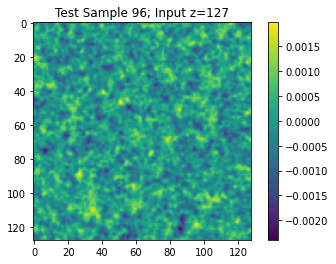

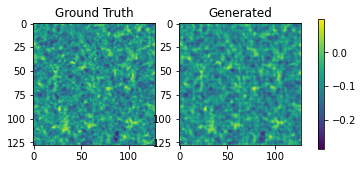

Correlation coefficient: 0.8148462948233712
Correlation coefficient before projection: 0.8425030359935455
avg should be 0, train sample:  -0.088883124
avg should be 0, gen sample:  -0.09054434


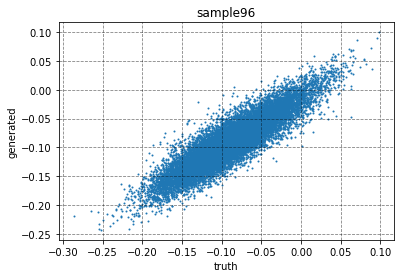

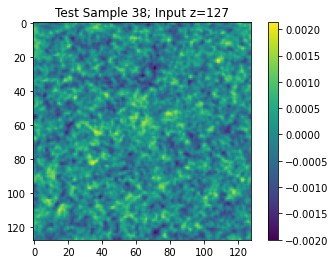

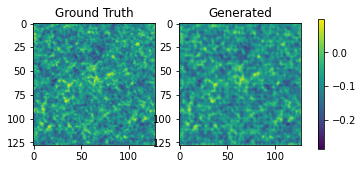

Correlation coefficient: 0.7263510890242119
Correlation coefficient before projection: 0.8453947335879747
avg should be 0, train sample:  -0.08846293
avg should be 0, gen sample:  -0.08974202


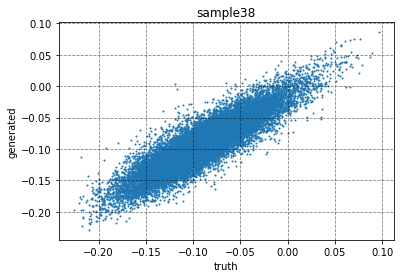

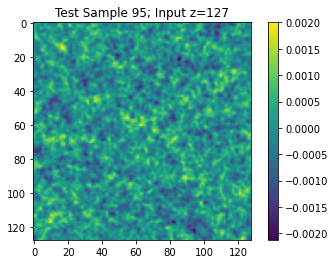

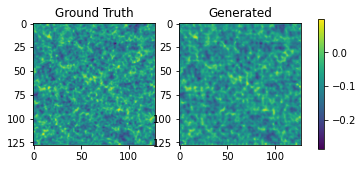

Correlation coefficient: 0.7298138308850894


FileNotFoundError: [Errno 2] No such file or directory: '/users/dbhatnagar/test_July5_B/ground_truth29.npy'

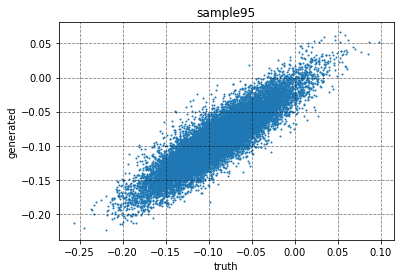

<Figure size 432x288 with 0 Axes>

In [15]:
#Without loading model, takes 100 test samples (already created), gives 5 random samples and statistics 

#plots of samples
test_length=5 #number of test samples wanted
#present_dir='/vol/calvin/data/dbhatnagar/Results_Summary/F_I_120epoch/'
#present_dir='/vol/calvin/data/dbhatnagar/Results_Summary/F_I_45epoch/'

# common_dir='/vol/calvin/data/dbhatnagar/Results_Summary_En/'
# dir_cont=['I_F_192epoch/test_July5_B/','F_I_120epoch/']

#present_dir=common_dir + dir_cont[opt_val]

present_dir='/users/dbhatnagar/test_July5_B/'
for i in range(0,test_length):
    p=random_int = np.random.randint(1, 100)

    data1=np.load(present_dir + f'ground_truth{p}.npy')  #truth: already log transformed #dimensions 1 x 1 x 128 x 128 x 128
    data2=np.load(present_dir +  f'generated_sample{p}.npy')  #generated: already log transformed #dimensions 128 x 128 x 128
    if opt_val==0:
        data3=np.load(present_dir + f'initial_sample{p}.npy') #initial: already log transformed #dimensions 1 x 1 x 128 x 128 x 128
    else:
        data3=np.load(present_dir + f'final_sample{p}.npy') #final: already log transformed #dimensions 1 x 1 x 128 x 128 x 128


    data1=data1.squeeze(0)
    data1=data1.squeeze(0)
    data3=data3.squeeze(0)
    data3=data3.squeeze(0)
    # now everything is 128 x 128 x 128

    #To plot delta 
    #To plot log 10 +1 delta

    data1=inverse_log_transform(data1)
    data2=inverse_log_transform(data2)
    data3=inverse_log_transform(data3)

    data1=log10_transform(data1)
    data2=log10_transform(data2)
    data3=log10_transform(data3)
    

     
    correlation_coefficient = np.corrcoef(data1.flatten(), data2.flatten())[0, 1]
# Print the correlation coefficient
    print("Correlation coefficient before projection:", correlation_coefficient)
    print("avg should be 0, train sample: ", np.mean(data1))
    print("avg should be 0, gen sample: ", np.mean(data2))
    # plt.scatter(data1, data2,s=1)
    # plt.show()
    data1 = np.mean(data1[:,:,0:128], axis=2)
    data2 = np.mean(data2[:,:,0:128], axis=2)
    data3 = np.mean(data3[:,:,0:128], axis=2)
    if i==0:
        vmin = min(np.min(data1), np.min(data2))
        vmax = max(np.max(data1), np.max(data2))
        print(vmin,'vmin')
        print(vmax,'vmax')


    # Plot the third data
    #plt.figure()



    #im3 = ax3.imshow(data3, cmap='viridis')
    #cbar = fig.colorbar(im3, shrink=0.6)
    plt.imshow(data3,'viridis')
    plt.colorbar()
    z=['127','0']
    #mention if this is delta or log transformed
    #plt.title(f'(log like transformed Delta) Matter density field ')
    plt.title(f'Test Sample {p}; Input z={z[opt_val]}')
    #plt.figure()

    #plot on same color bar
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig, (ax1, ax2) = plt.subplots(1, 2)
   

# Plot the first data
    im1 = ax1.imshow(data1, cmap='viridis',vmin=vmin,vmax=vmax)
    ax1.set_title('Ground Truth')
    

# Plot the second data
    im2 = ax2.imshow(data2, cmap='viridis',vmin=vmin,vmax=vmax)
    ax2.set_title('Generated')

# Create a common colorbar
    cbar = fig.colorbar(im2,ax=[ax1, ax2], shrink=0.6)
    

# Display the plots
    #plt.imshow(vmin=vmin_,vmax=vmax_)
    plt.show()
    plt.figure()
    plt.grid(True, linestyle='--', alpha=0.5, zorder=1,color="black")

    plt.scatter(data1, data2,s=1)
    #array_2d = np.zeros((128, 128))
    correlation_coefficient = np.corrcoef(data1, data2)[0, 1]

# Print the correlation coefficient
    print("Correlation coefficient:", correlation_coefficient)

# Set axis labels
    plt.xlabel('truth')
    plt.ylabel('generated')
    plt.title(f'sample{p}')
    
    plt.figure()
    

In [21]:
#uses loaded model and computes stats on the whole test loader

test_length=100 #number of test samples
corr_coeff=[]    #linear correlation coefficient of each pair
i=0
rho1=[]         #non-linear 
pvalue1=[]
rho=0
p_value=0
div1=[]         
sub1=[]
sq1=[]
val_sub=0  
val_div=0
val_sq=0

for i, data in enumerate(test_loader):
    x, y = data
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    #size of both 1 x 1 x128 x128 x128
    x = x.to(device)
    y = y.to(device)
    


    generated_samples = generator_loaded(x)
    k = generated_samples[0].squeeze(0)
    k1 = k.cpu().detach()
    k2=k1.numpy()

    data1=y.cpu().numpy() #truth 1 x 1 x 128 x128 x128
    data1=data1.squeeze(0)
    data1=data1.squeeze(0)
    data3=x.cpu().numpy() #input (initial or final) 1 x 1 x128 x128 x128
    data3=data3.squeeze(0)
    data3=data3.squeeze(0)
    data2=k2 #generated #128 x 128 x 128

    # print(data1.shape)  #128 x 128 x 128
    # print(data2.shape) 
    # print(data3.shape)  #128 x 128 x 128
    data1 = np.mean(data1[:,:,0:128], axis=2)
    data2 = np.mean(data2[:,:,0:128], axis=2)
    correlation_coefficient = np.corrcoef(data1, data2)[0, 1]
    corr_coeff.append(correlation_coefficient)
    data1 = np.mean(data1[:,0:128], axis=1)
    data2 = np.mean(data2[:,0:128], axis=1)
    rho, p_value = spearmanr(data1, data2)
    rho1.append(rho)
    pvalue1.append(p_value)
    val_div=data1/data2
    val_sub=data1-data2
    val_sq=(data1**2)-(data2**2)
    div1.append(val_div)
    sub1.append(val_sub)
    sq1.append(val_sq)

print(np.mean(div1),'div')
print(np.mean(sub1),'sub')
print(np.mean(sq1),'sq')
print("Spearman's rank correlation coefficient:", np.mean(rho1))
print("p-value:", np.mean(pvalue1))
print("Correlation coefficient:", np.mean(corr_coeff))



    


0.98366374 div
0.010459578 sub
-0.013268752 sq
Spearman's rank correlation coefficient: 0.7599666088776064
p-value: 1.8500041434208825e-11
Correlation coefficient: 0.762944288821912


In [14]:
# Power spectrum estimator for sim box (zeroth order)
def Pkest(dens_ff,P_range,N_g,N_kbins):
    
    L = P_range/N_g
    k_f = 2*np.pi/P_range
    k_nyq = np.pi*N_g/P_range
    dk = k_f

    k_bins = np.arange(1,N_kbins+1,1)*dk
    Pw_k = np.zeros_like(k_bins)
    N_k = np.zeros_like(k_bins)    

    ii = np.indices((N_g,N_g,N_g))
    kk = id_to_mode(ii, N_g)*k_f
    k_abs = np.sqrt(kk[0]**2 + kk[1]**2 + kk[2]**2)
    
    for i,k_curr in enumerate(k_bins):

        k_low = k_curr - dk/2
        k_high = k_curr + dk/2

        dens_curr = dens_ff[np.where((k_abs>k_low) & (k_abs<k_high))]
        
        real_denscurr = np.absolute(dens_curr)**2
                
        V = P_range**3
        
        Pw_k[i] = np.mean(real_denscurr)*V/N_g**6  
        
        N_k[i] = dens_curr.size
    
    return k_bins, Pw_k, N_k


def id_to_mode(ii, N):
    out = np.copy(ii)
    out[ii > N/2] -= N
    return out

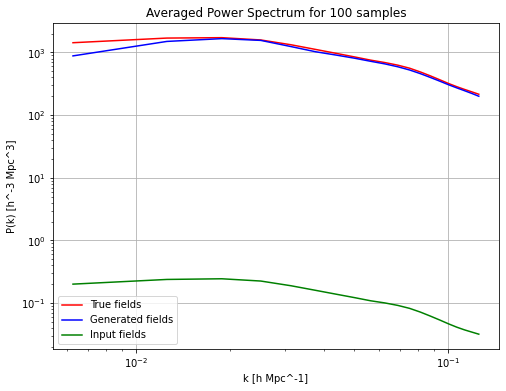

In [15]:
#power spectrum of test loader: gen vs true 100 samples

# Number of density fields
num_fields = 100
N_kbins=20
# Initialize arrays to accumulate individual power spectra
avg_Pw_k_1 = np.zeros(N_kbins)
avg_N_k_1 = np.zeros(N_kbins)
avg_Pw_k_2 = np.zeros(N_kbins)
avg_N_k_2 = np.zeros(N_kbins)
avg_Pw_k_3 = np.zeros(N_kbins)
avg_N_k_3 = np.zeros(N_kbins)
P_range=1000
N_g=128

# Iterate through your 20 density fields
for i, data in enumerate(test_loader):
    x, y = data
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    #size of both 1 x 1 x128 x128 x128
    x = x.to(device)
    y = y.to(device)
    generated_samples = generator_loaded(x)
    k = generated_samples[0].squeeze(0)
    k1 = k.cpu().detach()
    k2=k1.numpy()

    data1=y.cpu().numpy() #truth 1 x 1 x 128 x128 x128
    data1=data1.squeeze(0)
    data1=data1.squeeze(0)
    data3=x.cpu().numpy() #input (initial or final) 1 x 1 x128 x128 x128
    data3=data3.squeeze(0)
    data3=data3.squeeze(0)
    data2=k2 #generated #128 x 128 x 128
    # Load or generate your density field data into the 'dens_ff' variable
    # Replace this line with code to load/generate your data
    dens_ff_true=np.fft.fftn(data1)
    dens_ff_fake=np.fft.fftn(data2)
    dens_ff_input=np.fft.fftn(data3)

    # Execute the power spectrum estimation
    k_bins_1, Pw_k_1, N_k_1 = Pkest(dens_ff_true, P_range, N_g, N_kbins)
    k_bins_2, Pw_k_2, N_k_2 = Pkest(dens_ff_fake, P_range, N_g, N_kbins)
    k_bins_3, Pw_k_3, N_k_3 = Pkest(dens_ff_input, P_range, N_g, N_kbins)

    # Accumulate the individual power spectra
    avg_Pw_k_1 += Pw_k_1
    avg_N_k_1 += N_k_1
    avg_Pw_k_2 += Pw_k_2
    avg_N_k_2 += N_k_2
    avg_Pw_k_3 += Pw_k_3
    avg_N_k_3 += N_k_3


# Calculate the averaged power spectrum
avg_Pw_k_1 /= num_fields
avg_N_k_1 /= num_fields
avg_Pw_k_2 /= num_fields
avg_N_k_2 /= num_fields
avg_Pw_k_3 /= num_fields
avg_N_k_3 /= num_fields

# Plot the averaged power spectrum
plt.figure(figsize=(8, 6))
plt.loglog(k_bins_1, avg_Pw_k_1,'r',label='True fields')
plt.loglog(k_bins_2, avg_Pw_k_2,'b',label='Generated fields')
plt.loglog(k_bins_3, avg_Pw_k_3,'g',label='Input fields')
plt.xlabel('k [h Mpc^-1]')
plt.ylabel('P(k) [h^-3 Mpc^3]')
plt.title('Averaged Power Spectrum for 100 samples')
plt.grid(True)
plt.legend()
plt.show()

In [59]:
def flatten_and_normalize(arrays_list):
    flattened_list = [array.flatten() for array in arrays_list]
    normalized_list = [flat_array / np.sum(flat_array) for flat_array in flattened_list]
    return normalized_list

def kl_divergence(p, q):
    return np.sum(kl_div(p, q))

# Example: Generating two lists of 10 arrays of size 128x128x128 with random values
#np.random.seed(42)
list1 = load_sample_True
list2 = load_sample_Gen

# Step 1: Flatten and normalize arrays in each list
normalized_list1 = flatten_and_normalize(list1)
normalized_list2 = flatten_and_normalize(list2)

#plt.plot(normalized_list1)

# Step 3: Calculate KL divergence for each pair of arrays and average them
total_kl_divergence = 0
kl_div_i=0
for i in range(100):
    kl_div_i = kl_divergence(normalized_list1[i], normalized_list2[i])
    total_kl_divergence += kl_div_i

average_kl_divergence = total_kl_divergence / 100

print("Average KL Divergence:", average_kl_divergence)
plt.plot(total_kl_divergence)

0.6554172 div
0.34416577 sub
-0.5396582 sq
Spearman's rank correlation coefficient: 0.16275834340424622
p-value: 0.37700570323157817
Correlation coefficient: 0.7070442005757402
